### outline
1. Fit Alpha by EpochAI data

2. Predict carbon for unrecorded model

### 1. Fit Alpha

In [1]:
import pandas as pd
import numpy as np

data_df = pd.read_csv('notable_ai_models.csv')
df = data_df[['System','Training compute (FLOP)','Training time (hours)','Training hardware','Hardware quantity','Publication date']].dropna()
print(df)

FileNotFoundError: [Errno 2] No such file or directory: 'data/notable_ai_models.csv'

In [4]:
import os
print(os.getcwd())

/Users/frisolyppens/thesis_files/OpenCarbonEval/OpenCarbonEval/code


In [10]:
data_df = pd.read_csv('../data/notable_ai_models.csv')
df = data_df[['System','Training compute (FLOP)','Training time (hours)','Training hardware','Hardware quantity','Publication date']].dropna()
print(df)

                             System  Training compute (FLOP)  \
5                    Llama 3.1-405B             3.800000e+25   
11                          OpenVLA             1.100000e+23   
19           MegaScale (Production)             1.200000e+25   
34                 Gemini 1.0 Ultra             5.000000e+25   
41                    Nemotron-3-8B             1.800000e+23   
..                              ...                      ...   
543                        Xception             4.360000e+20   
565  Part-of-sentence tagging model             1.454112e+17   
566  Named Entity Recognition model             9.694080e+16   
582           DeepSpeech2 (English)             2.600000e+19   
619                           VGG16             1.229100e+19   

     Training time (hours)           Training hardware  Hardware quantity  \
5                   2142.0       NVIDIA H100 SXM5 80GB            16000.0   
11                   336.0                 NVIDIA A100               64.0   


In [8]:
print(29.268e12 * 24*3600*0.4889)

1.23630841728e+18


In [11]:
new_row = {
    'System': 'Transformer_opus_books_1',
    'Training compute (FLOP)': 1.23630841728e+18,
    'Training time (hours)':11.8,
    'Training hardware': 'NVIDIA L4',
    'Hardware quantity': 1,
    'Publication date': '2025-05-01chrom'
}

new_row_df = pd.DataFrame([new_row])

df = pd.concat([df, new_row_df], ignore_index=True)

print(df.tail())  

                             System  Training compute (FLOP)  \
107  Part-of-sentence tagging model             1.454112e+17   
108  Named Entity Recognition model             9.694080e+16   
109           DeepSpeech2 (English)             2.600000e+19   
110                           VGG16             1.229100e+19   
111        Transformer_opus_books_1             1.236308e+18   

     Training time (hours)           Training hardware  Hardware quantity  \
107                   12.0  NVIDIA GeForce GTX TITAN X                1.0   
108                    8.0  NVIDIA GeForce GTX TITAN X                1.0   
109                  120.0  NVIDIA GeForce GTX TITAN X               16.0   
110                  504.0      NVIDIA GTX Titan Black                4.0   
111                   11.8                   NVIDIA L4                1.0   

    Publication date  
107       2016-05-29  
108       2016-05-29  
109       2015-12-08  
110       2014-09-04  
111  2025-05-01chrom  


In [12]:
data_df[['System','Training compute (FLOP)','Training time (hours)','Training hardware','Hardware quantity','Publication date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   System                   867 non-null    object 
 1   Training compute (FLOP)  419 non-null    float64
 2   Training time (hours)    191 non-null    float64
 3   Training hardware        252 non-null    object 
 4   Hardware quantity        155 non-null    float64
 5   Publication date         867 non-null    object 
dtypes: float64(3), object(3)
memory usage: 40.8+ KB


In [13]:
df = df[df['System'] != 'IMPALA']     # P100 outliner

In [14]:
data_df.iloc[df.index]['Domain'].unique()

array(['Language', 'Robotics', 'Biology', 'Multimodal,Language,Vision',
       'Robotics,Vision,Language',
       'Multimodal,Language,Audio,Speech,Vision', 'Video',
       'Language,Multimodal', 'Mathematics', 'Mathematics,Language',
       'Multimodal,Language,Vision,Audio', 'Language,Search',
       'Vision,Language', 'Speech,Language', 'Speech',
       'Language,Speech,Audio', 'Earth science',
       'Language,Multimodal,Vision', 'Vision,Language,Multimodal',
       'Audio,Speech',
       'Multimodal,Vision,Speech,Language,Video,3D modeling',
       'Multimodal,Vision,Language,Image generation',
       'Multimodal,Vision,Language', 'Image generation',
       'Multimodal,Language,Video,Image generation',
       'Language,Image generation', 'Audio',
       'Multimodal,Language,Vision,Video',
       'Multimodal,Vision,Speech,Language',
       'Multimodal,Vision,Audio,Language,Image generation,Speech',
       'Vision'], dtype=object)

In [15]:
df['Domain'] = data_df.iloc[df.index]['Domain']
df['Publication date'] = data_df.iloc[df.index]['Publication date']

In [18]:
v = 37000
embedding_vector = 512
p = 512
l = 12
h = 2048


total_params = (
    embedding_vector * (v + p)
  + l * (12 * embedding_vector**2 + 13 * embedding_vector)
  + 2 * embedding_vector
)
print("Total parameters:", total_params)

Total parameters: 57035776


In [17]:
from scipy.optimize import fsolve


def equation_x(a, x, b):
    return np.log(1+a*x) / a + x * np.log(1+a*x) - x - b

new_b = df['Training compute (FLOP)'].values/1e12     # tflops
new_x = df['Training time (hours)'].values * 3600 * df['Hardware quantity'].values   # gputime(s)
gpu_nums = df['Hardware quantity']

solutions = []

for x, b, n in zip(new_x, new_b, gpu_nums):
    solution = fsolve(equation_x, x0=1e-10, args=(x, b))
    # print(f'''{x/3600}--{b/1e9}--{n}--{solution}--{np.log(solution)/np.log(10)}''')
    solutions.append(solution[0])

df['alpha'] = solutions
df['lg_alpha'] = df['alpha'].apply(lambda x: np.log10(x))

/var/folders/kq/d2bqp86d46d4xmpxm5rx24pm0000gn/T/ipykernel_76316/3983758501.py:14: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  solution = fsolve(equation_x, x0=1e-10, args=(x, b))
/var/folders/kq/d2bqp86d46d4xmpxm5rx24pm0000gn/T/ipykernel_76316/3983758501.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(equation_x, x0=1e-10, args=(x, b))


In [19]:
stats = df.groupby('Training hardware')['lg_alpha'].agg(['count', 'mean', 'std', 'min', 'max'])

stats


,count,mean,std,min,max
Training hardware,,,,,
Google TPU v2,3,-0.834451,0.455765,-1.314494,-0.407639
"Google TPU v2,Google TPU v1",1,28.201351,NaN,28.201351,28.201351
Google TPU v3,23,8.298062,5.893003,-7.746600,20.923008
Google TPU v4,11,32.982314,32.315172,-4.990120,111.508908
Huawei Ascend 910,1,36.636204,NaN,36.636204,36.636204
NVIDIA A100,17,36.422399,28.395376,-5.592592,110.906848
NVIDIA A100 SXM4 40 GB,10,36.870992,29.558879,2.387785,111.809938
NVIDIA A100 SXM4 80 GB,6,39.202408,12.173423,23.240501,54.809689
NVIDIA A800,1,53.860444,NaN,53.860444,53.860444


In [20]:

GPU_alpha = stats.transpose()
GPU_alpha

Training hardware,Google TPU v2,"Google TPU v2,Google TPU v1",Google TPU v3,Google TPU v4,Huawei Ascend 910,NVIDIA A100,NVIDIA A100 SXM4 40 GB,NVIDIA A100 SXM4 80 GB,NVIDIA A800,NVIDIA GTX Titan Black,...,NVIDIA Quadro P600,NVIDIA Quadro RTX 4000,NVIDIA Quadro RTX 5000,NVIDIA TITAN Xp,NVIDIA Tesla K40s,NVIDIA Tesla K40t,NVIDIA Tesla K80,NVIDIA Tesla V100 DGXS 32 GB,NVIDIA Tesla V100S PCIe 32 GB,NVIDIA V100
count,3.000000,1.000000,23.000000,11.000000,1.000000,17.000000,10.000000,6.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,5.000000,1.000000,12.000000
mean,-0.834451,28.201351,8.298062,32.982314,36.636204,36.422399,36.870992,39.202408,53.860444,-5.829111,...,-6.840154,-5.890671,5.719415,-3.767834,-7.565672,-6.952723,-6.596338,-1.233599,5.455841,3.475186
std,0.455765,NaN,5.893003,32.315172,NaN,28.395376,29.558879,12.173423,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.007378,2.398495,NaN,6.896571
min,-1.314494,28.201351,-7.746600,-4.990120,36.636204,-5.592592,2.387785,23.240501,53.860444,-5.829111,...,-6.840154,-5.890671,5.719415,-3.767834,-7.565672,-6.952723,-6.601555,-4.133616,5.455841,-5.357286
max,-0.407639,28.201351,20.923008,111.508908,36.636204,110.906848,111.809938,54.809689,53.860444,-5.829111,...,-6.840154,-5.890671,5.719415,-3.767834,-7.565672,-6.952723,-6.591121,1.452895,5.455841,15.529053


In [21]:

# 合并特定的Training hardware类别
hardware_mapping = {
    'NVIDIA A100 SXM4 40 GB': 'NVIDIA A100',
    'NVIDIA A100 SXM4 80 GB': 'NVIDIA A100',
    'NVIDIA GTX Titan Black': 'NVIDIA GTX Titan',
    'NVIDIA GeForce GTX TITAN X': 'NVIDIA GTX Titan',
    'NVIDIA Tesla K40s': 'NVIDIA Tesla K40',
    'NVIDIA Tesla K40t': 'NVIDIA Tesla K40',
    'NVIDIA Tesla V100 DGXS 32 GB': 'NVIDIA V100',
    'NVIDIA Tesla V100S PCIe 32 GB': 'NVIDIA V100',
    'NVIDIA H100 SXM5 80GB': 'NVIDIA H100',
}
df['Training hardware'] = df['Training hardware'].map(hardware_mapping).fillna(df['Training hardware'])



In [22]:
merge_stats = df.groupby('Training hardware')['lg_alpha'].agg(['count', 'mean', 'std', 'min', 'max'])

merge_stats

,count,mean,std,min,max
Training hardware,,,,,
Google TPU v2,3,-0.834451,0.455765,-1.314494,-0.407639
"Google TPU v2,Google TPU v1",1,28.201351,NaN,28.201351,28.201351
Google TPU v3,23,8.298062,5.893003,-7.746600,20.923008
Google TPU v4,11,32.982314,32.315172,-4.990120,111.508908
Huawei Ascend 910,1,36.636204,NaN,36.636204,36.636204
NVIDIA A100,33,37.063792,25.944697,-5.592592,111.809938
NVIDIA A800,1,53.860444,NaN,53.860444,53.860444
NVIDIA GTX Titan,5,-4.204724,1.442535,-5.829111,-2.594697
NVIDIA GeForce GTX 1080 Ti,1,-2.309782,NaN,-2.309782,-2.309782


In [23]:
merge_GPU_alpha = merge_stats.transpose()
merge_GPU_alpha

Training hardware,Google TPU v2,"Google TPU v2,Google TPU v1",Google TPU v3,Google TPU v4,Huawei Ascend 910,NVIDIA A100,NVIDIA A800,NVIDIA GTX Titan,NVIDIA GeForce GTX 1080 Ti,NVIDIA GeForce RTX 3090,...,NVIDIA L4,NVIDIA M40,NVIDIA P100,NVIDIA Quadro P600,NVIDIA Quadro RTX 4000,NVIDIA Quadro RTX 5000,NVIDIA TITAN Xp,NVIDIA Tesla K40,NVIDIA Tesla K80,NVIDIA V100
count,3.000000,1.000000,23.000000,11.000000,1.000000,33.000000,1.000000,5.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,18.000000
mean,-0.834451,28.201351,8.298062,32.982314,36.636204,37.063792,53.860444,-4.204724,-2.309782,-5.592592,...,8.445515,-4.778979,-4.165596,-6.840154,-5.890671,5.719415,-3.767834,-7.259198,-6.596338,2.277226
std,0.455765,NaN,5.893003,32.315172,NaN,25.944697,NaN,1.442535,NaN,NaN,...,NaN,NaN,0.695183,NaN,NaN,NaN,NaN,0.433421,0.007378,6.112451
min,-1.314494,28.201351,-7.746600,-4.990120,36.636204,-5.592592,53.860444,-5.829111,-2.309782,-5.592592,...,8.445515,-4.778979,-4.657164,-6.840154,-5.890671,5.719415,-3.767834,-7.565672,-6.601555,-5.357286
max,-0.407639,28.201351,20.923008,111.508908,36.636204,111.809938,53.860444,-2.594697,-2.309782,-5.592592,...,8.445515,-4.778979,-3.674028,-6.840154,-5.890671,5.719415,-3.767834,-6.952723,-6.591121,15.529053


In [24]:
df

,System,Training compute (FLOP),Training time (hours),Training hardware,Hardware quantity,Publication date,Domain,alpha,lg_alpha
0,Llama 3.1-405B,3.800000e+25,2142.0,NVIDIA H100,16000.0,2024-09-19,Language,8.069531e+110,110.906848
1,OpenVLA,1.100000e+23,336.0,NVIDIA A100,64.0,2024-08-07,Robotics,1.023010e-05,-4.990120
2,MegaScale (Production),1.200000e+25,504.0,NVIDIA A100,12288.0,2024-07-29,Language,8.069531e+110,110.906848
3,Gemini 1.0 Ultra,5.000000e+25,2400.0,Google TPU v4,55000.0,2024-07-29,Language,2.840444e+34,34.453386
4,Nemotron-3-8B,1.800000e+23,456.0,NVIDIA A100,1024.0,2024-07-24,Language,5.159911e+37,37.712642
...,...,...,...,...,...,...,...,...,...
107,Part-of-sentence tagging model,1.454112e+17,12.0,NVIDIA GTX Titan,1.0,2023-03-29,Video,1.695165e-03,-2.770788
108,Named Entity Recognition model,9.694080e+16,8.0,NVIDIA GTX Titan,1.0,2023-03-21,Image generation,2.542748e-03,-2.594697
109,DeepSpeech2 (English),2.600000e+19,120.0,NVIDIA GTX Titan,16.0,2023-03-20,Language,1.606853e-05,-4.794024
110,VGG16,1.229100e+19,504.0,NVIDIA GTX Titan,4.0,2023-03-20,Video,1.482140e-06,-5.829111


In [25]:
len(df['Training hardware'].unique())

21

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 定义一个函数来筛选数据
def filter_data(df, column):
    # 对每个类别进行操作
    for hardware in df['Training hardware'].unique():
        # 获取当前类别的数据
        subset = df[df['Training hardware'] == hardware][column]

        if hardware in ['Google TPU v2', 'NVIDIA Tesla K80', 'NVIDIA P100', 'NVIDIA H100']:
            continue
        
        # 如果数据少于5条，则剔除整个类别
        elif len(subset) < 5:
            df = df[df['Training hardware'] != hardware]
        else:
            # 计算上下分位数和IQR
            Q1 = subset.quantile(0.1)
            Q3 = subset.quantile(0.9)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # 剔除前10%和后10%的数据点
            df = df[(df['Training hardware'] != hardware) | (subset >= lower_bound) & (subset <= upper_bound)]
    
    return df

# 应用筛选函数
df_filtered = filter_data(df, 'lg_alpha')

In [28]:
df_filtered.shape

(98, 9)

In [29]:
df_filtered

,System,Training compute (FLOP),Training time (hours),Training hardware,Hardware quantity,Publication date,Domain,alpha,lg_alpha
0,Llama 3.1-405B,3.800000e+25,2142.0,NVIDIA H100,16000.0,2024-09-19,Language,8.069531e+110,110.906848
1,OpenVLA,1.100000e+23,336.0,NVIDIA A100,64.0,2024-08-07,Robotics,1.023010e-05,-4.990120
2,MegaScale (Production),1.200000e+25,504.0,NVIDIA A100,12288.0,2024-07-29,Language,8.069531e+110,110.906848
3,Gemini 1.0 Ultra,5.000000e+25,2400.0,Google TPU v4,55000.0,2024-07-29,Language,2.840444e+34,34.453386
4,Nemotron-3-8B,1.800000e+23,456.0,NVIDIA A100,1024.0,2024-07-24,Language,5.159911e+37,37.712642
...,...,...,...,...,...,...,...,...,...
106,Xception,4.360000e+20,720.0,NVIDIA Tesla K80,60.0,2023-03-30,Language,2.563768e-07,-6.591121
107,Part-of-sentence tagging model,1.454112e+17,12.0,NVIDIA GTX Titan,1.0,2023-03-29,Video,1.695165e-03,-2.770788
108,Named Entity Recognition model,9.694080e+16,8.0,NVIDIA GTX Titan,1.0,2023-03-21,Image generation,2.542748e-03,-2.594697
109,DeepSpeech2 (English),2.600000e+19,120.0,NVIDIA GTX Titan,16.0,2023-03-20,Language,1.606853e-05,-4.794024


In [30]:
filtered_stats = df_filtered.groupby('Training hardware')['lg_alpha'].agg(['count', 'mean', 'std', 'min', 'max'])

# 输出结果
filtered_stats

,count,mean,std,min,max
Training hardware,,,,,
Google TPU v2,3,-0.834451,0.455765,-1.314494,-0.407639
Google TPU v3,23,8.298062,5.893003,-7.746600,20.923008
Google TPU v4,11,32.982314,32.315172,-4.990120,111.508908
NVIDIA A100,33,37.063792,25.944697,-5.592592,111.809938
NVIDIA GTX Titan,5,-4.204724,1.442535,-5.829111,-2.594697
NVIDIA H100,1,110.906848,NaN,110.906848,110.906848
NVIDIA P100,2,-4.165596,0.695183,-4.657164,-3.674028
NVIDIA Tesla K80,2,-6.596338,0.007378,-6.601555,-6.591121
NVIDIA V100,18,2.277226,6.112451,-5.357286,15.529053


/var/folders/kq/d2bqp86d46d4xmpxm5rx24pm0000gn/T/ipykernel_76316/545768704.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Training hardware', y='lg_alpha', data=df_filtered, palette="Set2")


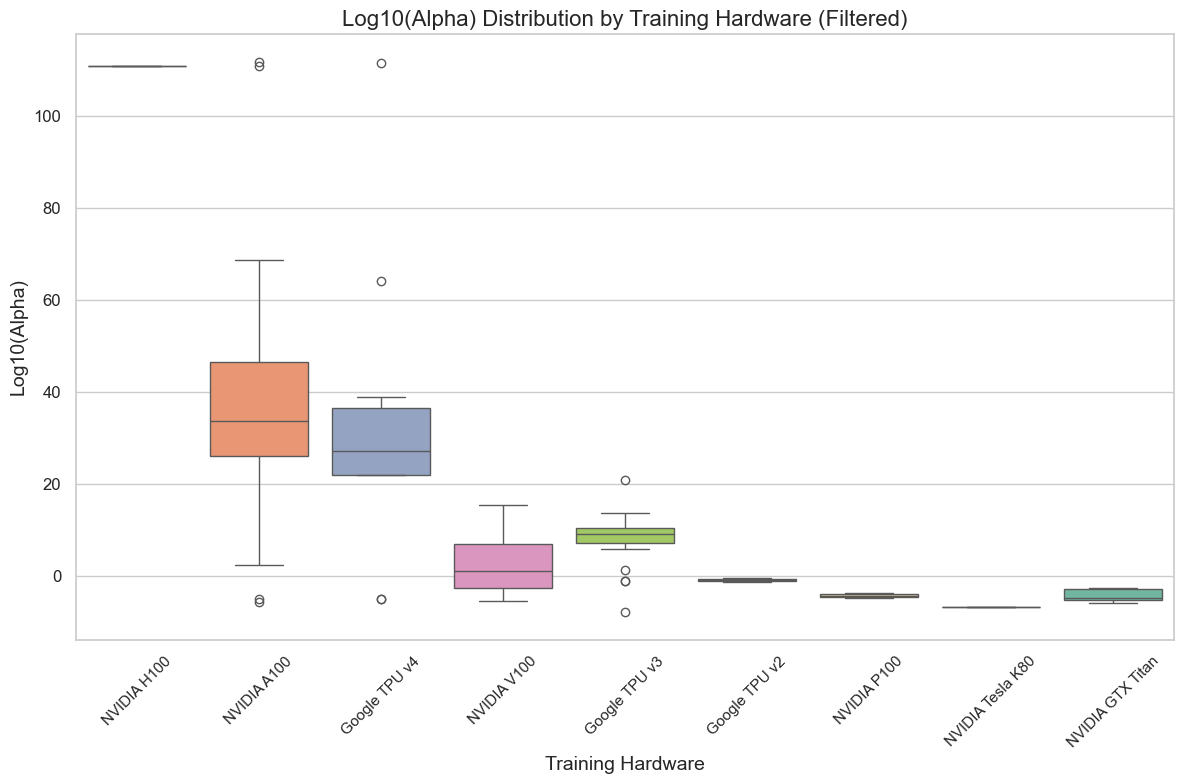

In [31]:
sns.set(style="whitegrid")

# 绘制箱型图
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Training hardware', y='lg_alpha', data=df_filtered, palette="Set2")
plt.title('Log10(Alpha) Distribution by Training Hardware (Filtered)', fontsize=16)
plt.xlabel('Training Hardware', fontsize=14)
plt.ylabel('Log10(Alpha)', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)
plt.tick_params(axis='both', which='major', length=7)
plt.tight_layout()

# # 保存图表
# plt.savefig('boxplot_log10_alpha_filtered.png', dpi=300)

plt.show()

/var/folders/kq/d2bqp86d46d4xmpxm5rx24pm0000gn/T/ipykernel_76316/3952555230.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  lineplot = sns.lineplot(x='Training hardware', y='mean', data=sorted_grouped, marker='o',lw=3, ci='sd')


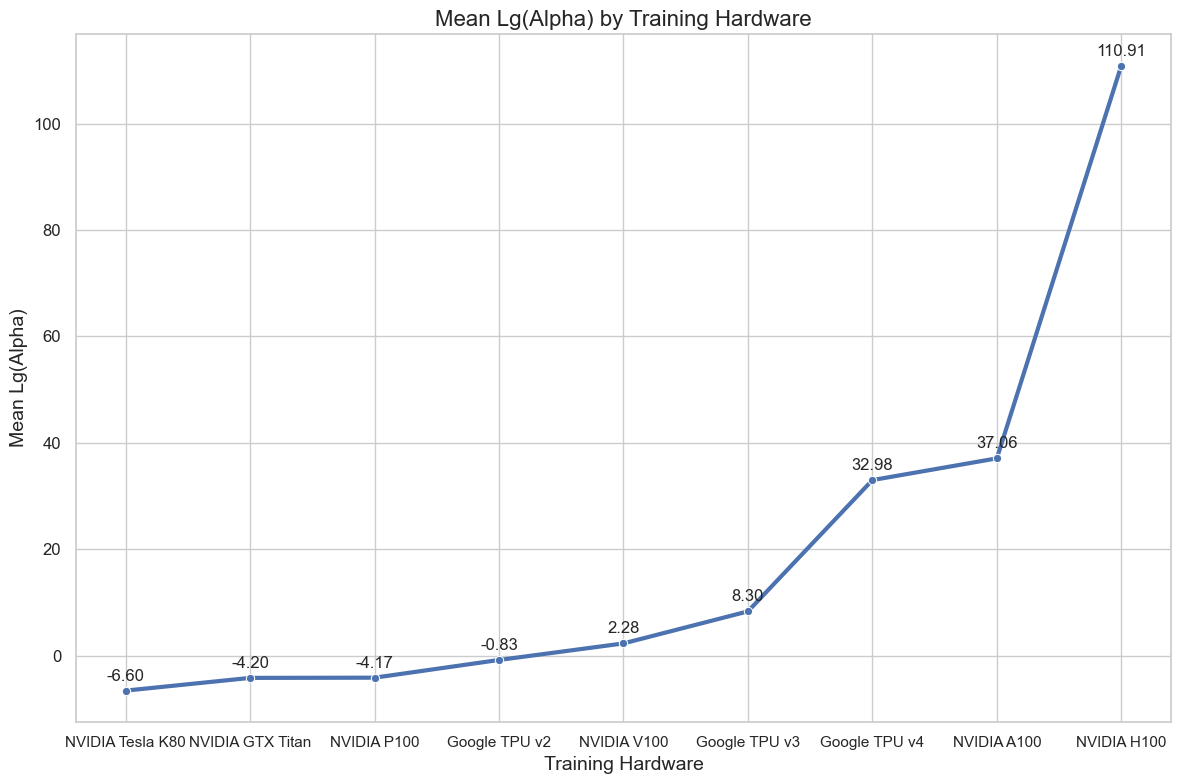

In [32]:
# 计算每个类别的均值和标准误差
grouped = df_filtered.groupby('Training hardware')['lg_alpha'].agg(['mean', 'sem']).reset_index()

# 按照均值进行排序
sorted_grouped = grouped.sort_values(by='mean')

# 设置Seaborn的样式
sns.set(style="whitegrid")

# 绘制折线图和置信区间
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(x='Training hardware', y='mean', data=sorted_grouped, marker='o',lw=3, ci='sd')

# 获取当前图的坐标轴
ax = plt.gca()
# 在每个点上添加文本标签
for i, point in enumerate(sorted_grouped['mean']):
    ax.annotate(f'{point:.2f}',  # 标注的文本，这里格式化为两位小数
                xy=(i, point),   # 标注的坐标位置
                xytext=(0, 5),   # 文本的偏移量
                textcoords='offset points',  # 偏移的类型
                ha='center',     # 水平对齐方式
                va='bottom')     # 垂直对齐方式


# 添加置信区间的阴影部分
# plt.fill_between(sorted_grouped['Training hardware'], 
#                  sorted_grouped['mean'] - sorted_grouped['sem'], 
#                  sorted_grouped['mean'] + sorted_grouped['sem'], 
#                  color="blue", alpha=0.2)

# plt.title('Mean Lg(Alpha) by Training Hardware with Confidence Interval', fontsize=16)
plt.title('Mean Lg(Alpha) by Training Hardware', fontsize=16)
plt.xlabel('Training Hardware', fontsize=14)
plt.ylabel('Mean Lg(Alpha)', fontsize=14)
plt.xticks(rotation=0)
plt.yticks(fontsize=12)
plt.tick_params(axis='both', which='major', length=7)
plt.tight_layout()

# # 保存图表
# plt.savefig('lineplot_with_confidence_interval.png', dpi=300)

plt.show()

/var/folders/kq/d2bqp86d46d4xmpxm5rx24pm0000gn/T/ipykernel_76316/472484510.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  lineplot = sns.lineplot(x=sorted_grouped['Training hardware'], y=peak_TFLOPS, marker='o', ci='sd', lw=3, color='orange')


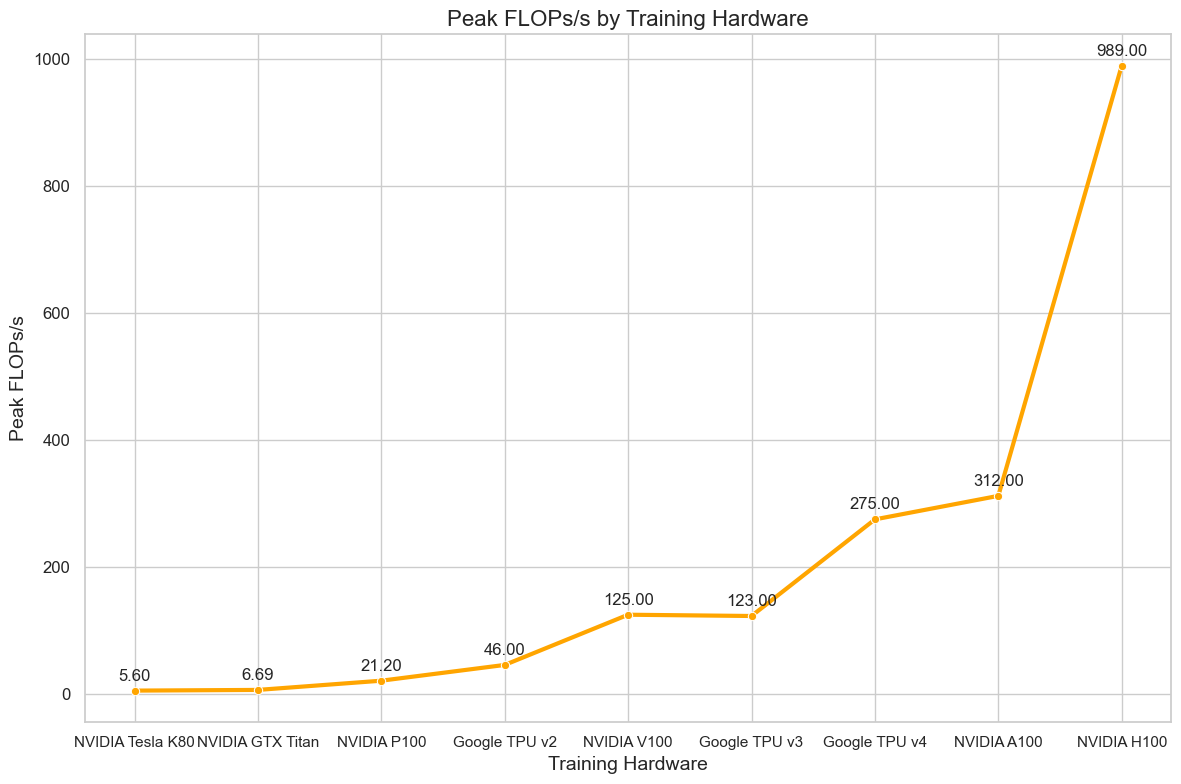

In [33]:
peak_TFLOPS = [5.6, 6.69, 21.2, 46, 125, 123, 275, 312, 989]
# 设置Seaborn的样式
sns.set(style="whitegrid")

# 绘制折线图和置信区间
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(x=sorted_grouped['Training hardware'], y=peak_TFLOPS, marker='o', ci='sd', lw=3, color='orange')

# 获取当前图的坐标轴
ax = plt.gca()
# 在每个点上添加文本标签
for i, point in enumerate(peak_TFLOPS):
    ax.annotate(f'{point:.2f}',  # 标注的文本，这里格式化为两位小数
                xy=(i, point),   # 标注的坐标位置
                xytext=(0, 5),   # 文本的偏移量
                textcoords='offset points',  # 偏移的类型
                ha='center',     # 水平对齐方式
                va='bottom')     # 垂直对齐方式



plt.title('Peak FLOPs/s by Training Hardware', fontsize=16)
plt.xlabel('Training Hardware', fontsize=14)
plt.ylabel('Peak FLOPs/s', fontsize=14)
plt.xticks(rotation=0)
plt.yticks(fontsize=12)
plt.tick_params(axis='both', which='major', length=7)
plt.tight_layout()

# # 保存图表
# plt.savefig('lineplot_with_confidence_interval.png', dpi=300)

plt.show()

/var/folders/kq/d2bqp86d46d4xmpxm5rx24pm0000gn/T/ipykernel_76316/1891920869.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=10)


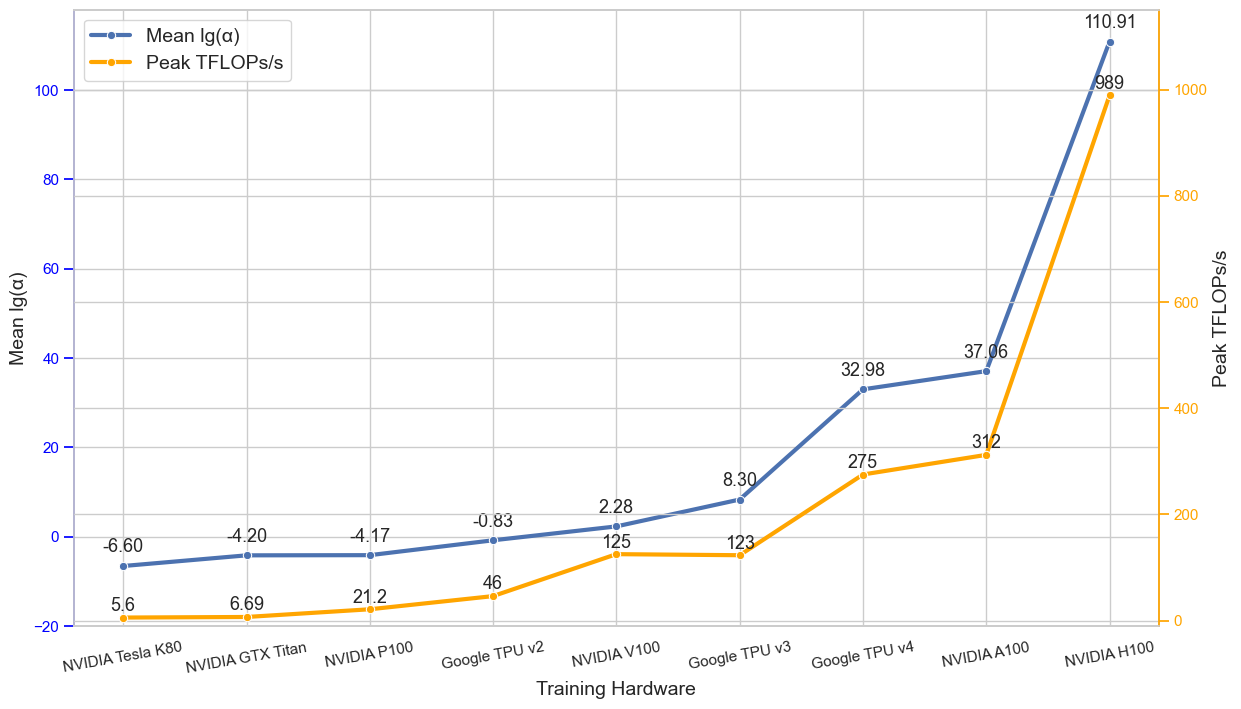

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 sorted_grouped 是之前定义的 DataFrame
# 假设 peak_TFLOPS 是之前定义的峰值 TFLOPS 数组

# 设置Seaborn的样式
sns.set(style="whitegrid")

# 创建一个新的图形
plt.figure(figsize=(14, 8))

# 创建一个轴对象
ax1 = plt.gca()

# 绘制第一条折线图（使用左侧y轴）
lineplot1 = sns.lineplot(
    x=sorted_grouped['Training hardware'],
    y=sorted_grouped['mean'],  # 假设这是之前计算的lg_alpha的均值
    ax=ax1,
    marker='o',
    lw=3,
    legend=True
)

# 设置左侧y轴的颜色
ax1.spines['left'].set_color('blue')
ax1.tick_params(axis='y', colors='blue')

for i, point in enumerate(sorted_grouped['mean']):
    ax1.annotate(f'{point:.2f}',  # 标注的文本，这里格式化为两位小数
                xy=(i, point),   # 标注的坐标位置
                xytext=(0, 7),   # 文本的偏移量
                textcoords='offset points',  # 偏移的类型
                ha='center',     # 水平对齐方式
                fontsize=13,
                va='bottom')     # 垂直对齐方式

# 创建另一个轴对象（共享x轴）
ax2 = ax1.twinx()

# 绘制第二条折线图（使用右侧y轴）
lineplot2 = sns.lineplot(
    x=sorted_grouped['Training hardware'],
    y=peak_TFLOPS,
    ax=ax2,
    marker='o',
    color='orange',
    lw=3,
    legend=True
)

for i, point in enumerate(peak_TFLOPS):
    ax2.annotate(f'{point}',    # 标注的文本
                xy=(i, point),   # 标注的坐标位置
                xytext=(0, 2),   # 文本的偏移量
                textcoords='offset points',  # 偏移的类型
                ha='center',     # 水平对齐方式
                fontsize=13,
                va='bottom')     # 垂直对齐方式

# 设置右侧y轴的颜色
ax2.spines['right'].set_color('orange')
ax2.tick_params(axis='y', colors='orange')


# 为左侧y轴设置显示范围
ax1.set_ylim(-20, 118) 
# 为右侧y轴设置显示范围
ax2.set_ylim(-10, 1150)

# 设置标题和坐标轴标签
# plt.title('Alpha/ by Training Hardware', fontsize=16)
ax1.set_xlabel('Training Hardware', fontsize=14)
ax1.set_ylabel('Mean lg(α)', fontsize=14)
ax2.set_ylabel('Peak TFLOPs/s', fontsize=14)
ax1.tick_params(axis='both', which='major', length=7)
ax2.tick_params(axis='both', which='major', length=7)

# 设置x轴标签旋转
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=10)
# 手动设置图例
lines = [lineplot1.lines[0], lineplot2.lines[0]]
labels = ['Mean lg(α)', 'Peak TFLOPs/s']
ax1.legend(lines, labels, loc='upper left', fontsize=14)

plt.savefig('alpha_and_flops_trends.png', dpi=300)

# 显示图表
plt.show()

In [35]:
sorted_grouped

,Training hardware,mean,sem
7,NVIDIA Tesla K80,-6.596338,0.005217
4,NVIDIA GTX Titan,-4.204724,0.645121
6,NVIDIA P100,-4.165596,0.491568
0,Google TPU v2,-0.834451,0.263136
8,NVIDIA V100,2.277226,1.440719
1,Google TPU v3,8.298062,1.228776
2,Google TPU v4,32.982314,9.743391
3,NVIDIA A100,37.063792,4.516392
5,NVIDIA H100,110.906848,NaN


In [36]:
box_x = []
box_y = []
for i in range(len(sorted_grouped)-1):
    hdw = sorted_grouped['Training hardware'].iloc[i]
    box_x.append(hdw)
    box_y.append(df_filtered[df_filtered['Training hardware'] == hdw]['lg_alpha'].values)

/var/folders/kq/d2bqp86d46d4xmpxm5rx24pm0000gn/T/ipykernel_76316/1520447016.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Training hardware', y='lg_alpha', data=df_filtered, palette="Set2", order=box_x)


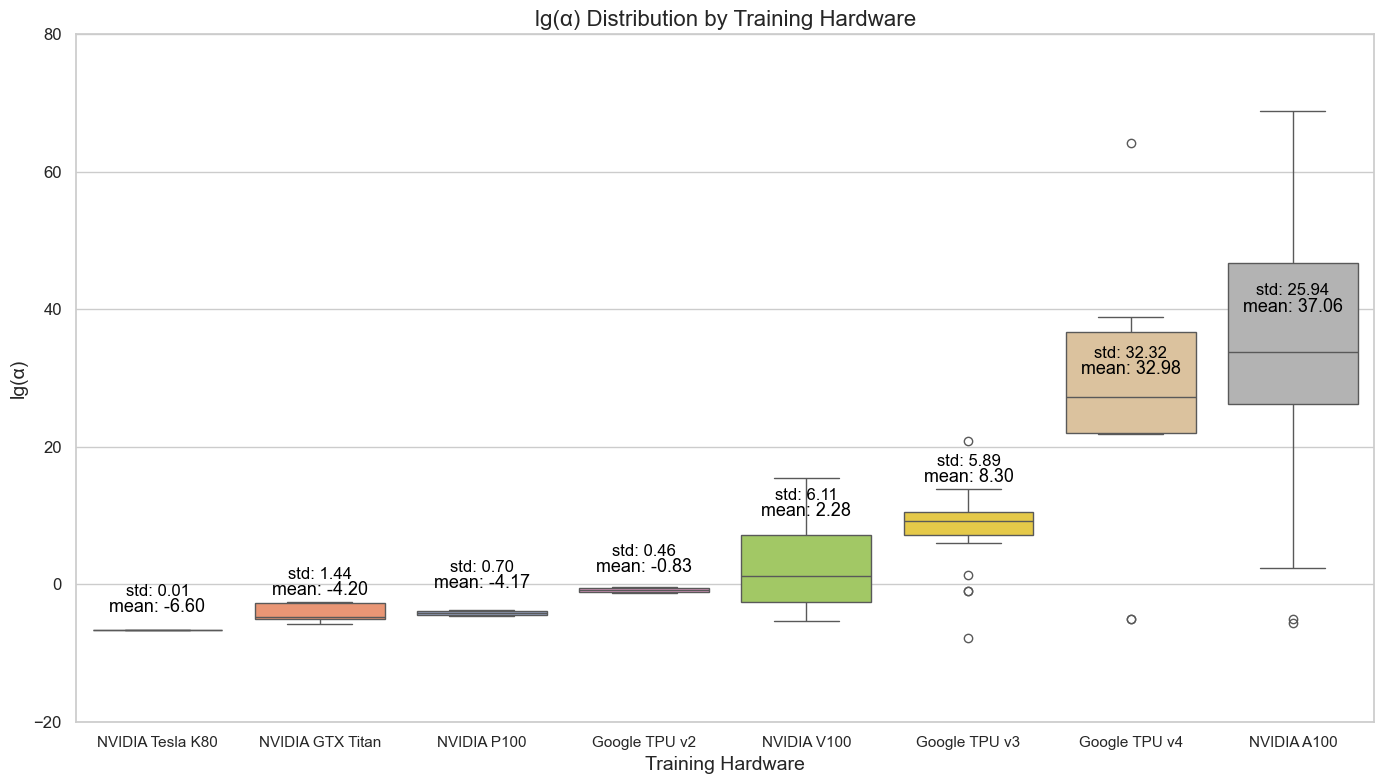

In [37]:
# 确保df_filtered按照给定顺序排序
df_filtered = df_filtered.set_index('Training hardware').loc[box_x].reset_index()

# 设置Seaborn的样式
sns.set(style="whitegrid")

# 绘制箱型图
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='Training hardware', y='lg_alpha', data=df_filtered, palette="Set2", order=box_x)

# 计算均值和标准差
mean_std = df_filtered.groupby('Training hardware')['lg_alpha'].agg(['mean', 'std']).reset_index()


y_offset = [0, 0, 1, 0, 5, 4, -5, 0]
# 在箱型图上标注均值和标准差
for i, hardware in enumerate(box_x):
    # 获取均值和标准差
    mean = mean_std.loc[mean_std['Training hardware'] == hardware, 'mean'].values[0]
    std = mean_std.loc[mean_std['Training hardware'] == hardware, 'std'].values[0]
    
    # 计算标注的y位置
    y_mean = mean + y_offset[i]
    y_std = y_mean + 0.5
    
    # 标注均值
    ax.annotate(f'mean: {mean:.2f}', xy=(i, y_mean), xytext=(0, 10),
                textcoords='offset points', ha='center', va='bottom', color='black', fontsize=13)
    
    # 标注标准差
    ax.annotate(f'std: {std:.2f}', xy=(i, y_std), xytext=(0, 20),
                textcoords='offset points', ha='center', va='bottom', color='black')

ax.set_ylim(-20, 80)
# 设置标题和坐标轴标签
plt.title('lg(α) Distribution by Training Hardware', fontsize=16)
plt.xlabel('Training Hardware', fontsize=14)
plt.ylabel('lg(α)', fontsize=14)
plt.xticks(rotation=0)
plt.yticks(fontsize=12)
plt.tick_params(axis='both', which='major', length=7)
plt.tight_layout()

plt.savefig('alpha_dist_box.png', dpi=300)

# 显示图表
plt.show()

In [38]:
# 对df添加新的一列mean_lg_alpha, 根据硬件类型匹配获得其对应硬件的平均lg_alpha值
def get_mean_lg_alpha(hardware):
    hardware_mapping = {
        'NVIDIA A100 SXM4 40 GB': 'NVIDIA A100',
        'NVIDIA A100 SXM4 80 GB': 'NVIDIA A100',
        'NVIDIA GTX Titan Black': 'NVIDIA GTX Titan',
        'NVIDIA GeForce GTX TITAN X': 'NVIDIA GTX Titan',
        'NVIDIA Tesla K40s': 'NVIDIA Tesla K40',
        'NVIDIA Tesla K40t': 'NVIDIA Tesla K40',
        'NVIDIA Tesla V100 DGXS 32 GB': 'NVIDIA V100',
        'NVIDIA Tesla V100S PCIe 32 GB': 'NVIDIA V100',
        'NVIDIA H100 SXM5 80GB': 'NVIDIA H100',
        'NVIDIA H100 SXM5': 'NVIDIA H100',
        # 'NVIDIA H100 SXM5': 'NVIDIA H100 SXM5 80GB',
    }
    if hardware in hardware_mapping:
        hardware = hardware_mapping[hardware]
    
    return merge_GPU_alpha.iloc[1][hardware]
df['mean_lg_alpha'] = df['Training hardware'].map(get_mean_lg_alpha)
df['mean_lg_alpha']

0      110.906848
1       37.063792
2       37.063792
3       32.982314
4       37.063792
          ...    
107     -4.204724
108     -4.204724
109     -4.204724
110     -4.204724
111      8.445515
Name: mean_lg_alpha, Length: 111, dtype: float64

In [25]:
df.to_csv('../data/OpenCarbonEval_dataset.csv', index=False)

### predict carbon

In [44]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, root_scalar
import pandas as pd
import numpy as np

df = pd.read_csv('../data/valid_models.csv')

new_b = df['Training compute (FLOP)'].values / 1e12
low = np.exp(np.log(10)*df['low_alpha'].values)
high = np.exp(np.log(10)*df['high_alpha'].values)
tdp = df['TDP'].values
i = df['kgco2/kwh']

hardware = df['Training hardware']
hardware_mapping = {
    'NVIDIA A100 SXM4 40 GB': 'NVIDIA A100',
    'NVIDIA A100 SXM4 80 GB': 'NVIDIA A100',
    'NVIDIA GTX Titan Black': 'NVIDIA GTX Titan',
    'NVIDIA GeForce GTX TITAN X': 'NVIDIA GTX Titan',
    'NVIDIA Tesla K40s': 'NVIDIA Tesla K40',
    'NVIDIA Tesla K40t': 'NVIDIA Tesla K40',
    'NVIDIA Tesla V100 DGXS 32 GB': 'NVIDIA V100',
    'NVIDIA Tesla V100S PCIe 32 GB': 'NVIDIA V100',
    'NVIDIA H100 SXM5 80GB': 'NVIDIA H100',
    'NVIDIA H100 SXM5': 'NVIDIA H100',
    # 'NVIDIA H100 SXM5': 'NVIDIA H100 SXM5 80GB',
}
hardware = hardware.map(hardware_mapping).fillna(hardware)
    
lg_alpha = merge_GPU_alpha.iloc[1][hardware.values]
alpha = np.exp(np.log(10)*lg_alpha.values)

def equation_a(x,a,b):
    return np.log(1+a*x) / a + x * np.log(1+a*x) - x - b

times = []

for x, b in zip(alpha, new_b):
    solution = fsolve(equation_a, x0=1e8, args=(x, b))
    # print(f'''{x/3600}--{b/1e9}--{n}--{solution}--{np.log(solution)/np.log(10)}''')
    times.append(solution[0])

energy = np.array(times) * tdp / 3600 / 1e6    # MWh
carbon = energy * i                           # tCO2

df['GPU_hours(h)'] = np.array(times) / 3600
df['Energy(MWh)'] = energy
df['Carbon(t)'] = carbon
# df
df = df.sort_values(by='Carbon(t)',ascending=False)

df.tail(10)

,Unnamed: 0,System,Training compute (FLOP),Task,Training hardware,Publication date,Country (from Organization),Main region,kgco2/kwh,low_alpha,high_alpha,TDP,trash_column,GPU_hours(h),Energy(MWh),Carbon(t)
0,501,Llama-3,6.300000e+24,"Chat,Language modelling/generation,Code genera...",NVIDIA H100 SXM5,2024/4/18,United States of America,United States of America,0.424,100.000000,110.000000,700,NaN,6.290085e+06,4403.059600,1866.897270
3,504,GLM,3.120000e+23,NaN,NVIDIA A100 SXM4 40 GB,NaN,NaN,NaN,0.581,31.930312,44.714006,400,NaN,8.165008e+05,326.600318,189.754785
1,502,BLOOM,3.870000e+23,Language modelling,NVIDIA A100 SXM4 80 GB,2022/11/8,"Multinational,Multinational",Multinational,0.057,36.112884,50.505783,400,NaN,1.010743e+06,404.297131,23.044936
2,503,StarCoder,9.300000e+22,Code generation,NVIDIA A100 SXM4 80 GB,2023/5/9,"Multinational,United States of America,United ...",Multinational,0.155,36.112884,50.505783,400,NaN,2.461608e+05,98.464308,15.261968
5,506,Swin-L,4.000000e+20,NaN,NVIDIA V100,NaN,NaN,NaN,0.369,-0.172627,10.469236,300,NaN,5.289572e+03,1.586872,0.585556
4,505,ViT-L/16,5.300000e+20,NaN,Google TPU v3,NaN,NaN,NaN,0.369,3.330417,13.139611,250,NaN,4.248828e+03,1.062207,0.391954
6,507,Transformer,1.236308e+18,NaN,NVIDIA L4,2025/5/1,NaN,NaN,0.451,8.445515,8.445515,71,NaN,1.180000e+01,0.000838,0.000378


In [46]:
carbon_pred = np.array([189.754785, 23.044936, 15.261968, 1866.89727, 0.391954, 0.585556, 0.000378])
actual_op_carbon = np.array([257, 24.7, 17.26, 1900, 2.71, 0.80, 0.00051773])
error_rate = (carbon_pred - actual_op_carbon) / actual_op_carbon
error_rate

array([-0.26165453, -0.06700664, -0.11576083, -0.01742249, -0.85536753,
       -0.268055  , -0.26988971])

In [41]:
gpu_h = np.array([
    816500.795231, 1.010743e+06, 246160.770290, 6.290085e+06, 4248.82755, 5289.572357, 1.18e1
])

embodied_i = np.array([1.5, 1.5, 1.5, 1.7, 0.8, 1.1])

embodied_carbon = gpu_h * embodied_i / 1000    # kgCO2
embodied_carbon

array([1.22475119e+03, 1.51611450e+03, 3.69241155e+02, 1.06931445e+04,
       3.39906204e+00, 5.81852959e+00])

In [42]:
actual_emb_carbon = np.array([1634.50, 1631.23, 480.38, 10880.0, 13.06, 7.92])
error_rate = (embodied_carbon - actual_emb_carbon) / actual_emb_carbon
error_rate

array([-0.25068755, -0.07056975, -0.2313561 , -0.01717422, -0.73973491,
       -0.26533717])